In [603]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import RFECV, RFE, SelectKBest, f_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt

In [604]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
min_max_scaler = MinMaxScaler()
standar_scaler = StandardScaler()
bc = PowerTransformer(method="box-cox")
yj = PowerTransformer(method="yeo-johnson")
rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal", random_state=rng)

In [605]:
def graficar_info_variable(variable, b=8):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(data=variable, bins=b ,ax=axes[0])
    sns.boxplot(data=variable, ax=axes[1])
    sns.violinplot(data=variable, ax=axes[2])

def porcentaje_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((data < BI) | (data > BS))
    print("Porcentaje de outliers: ", 100*out.sum()/out.count())

def quitar_outliers(data, df_feature):
    Q1 = df_feature.quantile(0.25)
    Q3 = df_feature.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((df_feature > BI) & (df_feature < BS))
    data = data.loc[out]
    return data

In [606]:
df = pd.read_csv('ToyotaCorolla_modificado - ToyotaCorolla_modificado.csv')
df.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,1,0,0,0,1,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,1,0,1,0,0,0,1,0,0,0
2,3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,0,1,0,0,0,1,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,0,1,0,0,0,1,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,1,0,1,0,1,0,0,0


In [607]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

In [608]:
df.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,...,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,721.555014,10730.824513,55.947075,5.548747,1999.625348,68533.259749,101.502089,0.674791,0.055710,1576.85585,...,0.580084,0.561978,0.977716,0.146240,0.256964,0.300139,0.770195,0.204735,0.145543,0.277855
std,416.476890,3626.964585,18.599988,3.354085,1.540722,37506.448872,14.981080,0.468616,0.229441,424.38677,...,0.493717,0.496317,0.147657,0.353469,0.437111,0.458478,0.420854,0.403649,0.352770,0.448098
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.750000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,721.500000,9900.000000,61.000000,5.000000,1999.000000,63389.500000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1081.250000,11950.000000,70.000000,8.000000,2001.000000,87020.750000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [609]:
#Eliminar signo de interrogación de modelo y calcular valores únicos
df.Model = df.Model.apply(lambda x: x.replace('?', ''))
print("Valores únicos de modelos: ",len(df.Model.value_counts()))

Valores únicos de modelos:  319


In [610]:
#Encoder Fuel Type
fuel_encoder = one_hot_encoder.fit(df.Fuel_Type.values.reshape(-1, 1))
name_fuel = fuel_encoder.categories_[0]
fuel_encoder = fuel_encoder.transform(df.Fuel_Type.values.reshape(-1, 1))
fuel_type_encoder = pd.DataFrame(fuel_encoder.toarray(), columns=name_fuel)
df = df.drop(columns=['Fuel_Type'])
df = pd.concat([df, fuel_type_encoder], axis=1)

In [611]:
drop_columns = ['Model', 'Id', 'Cylinders']

In [612]:
df = df.drop(columns=drop_columns)

#### Definir x e y

In [613]:
y = df.Price
x = df.drop(columns=['Price'])
names=pd.DataFrame(x.columns)

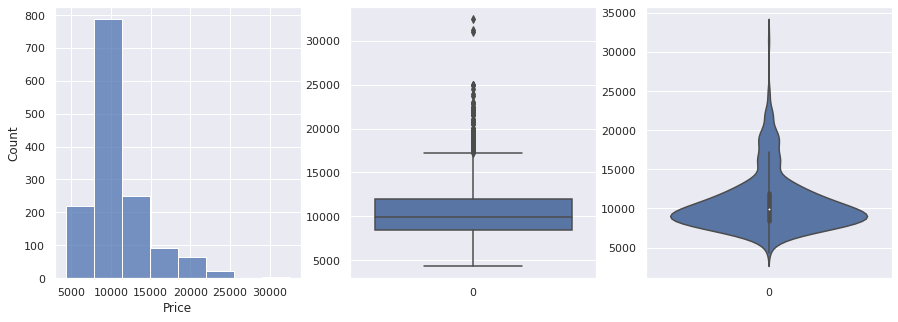

In [614]:
#Si modifico la variable price
#df.Price = np.log(df.Price)
graficar_info_variable(df.Price)

In [615]:
porcentaje_outliers(df.Price)

Porcentaje de outliers:  7.66016713091922


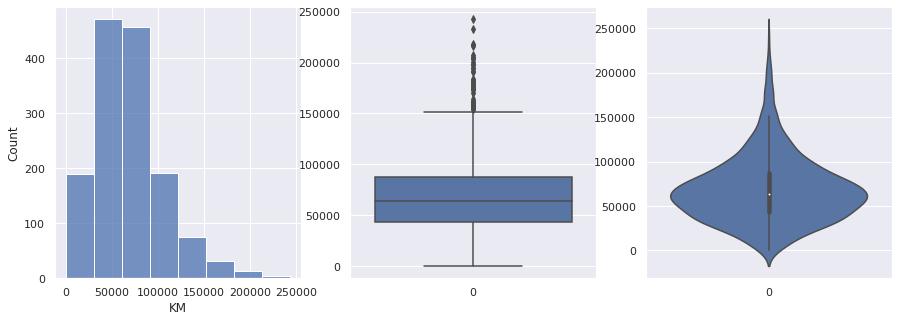

In [616]:
graficar_info_variable(df.KM)

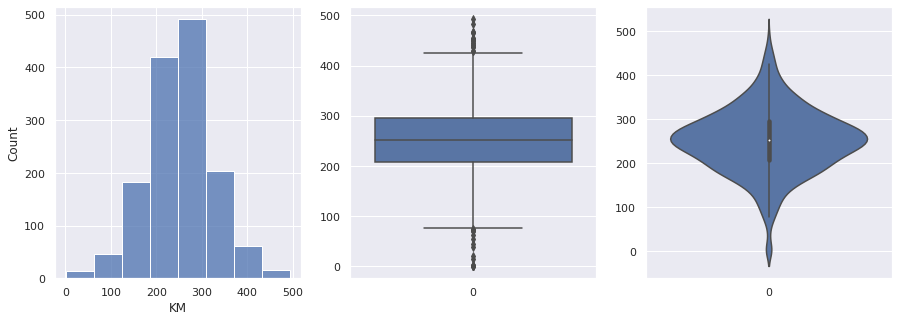

In [617]:
df.KM = np.sqrt(df.KM)
graficar_info_variable(df.KM)

In [618]:
porcentaje_outliers(df.KM)

Porcentaje de outliers:  2.6462395543175488


In [619]:
df = quitar_outliers(df, df.KM)
porcentaje_outliers(df.KM)

Porcentaje de outliers:  0.7153075822603719


In [620]:
df = quitar_outliers(df, df.KM)
porcentaje_outliers(df.KM)

Porcentaje de outliers:  0.0


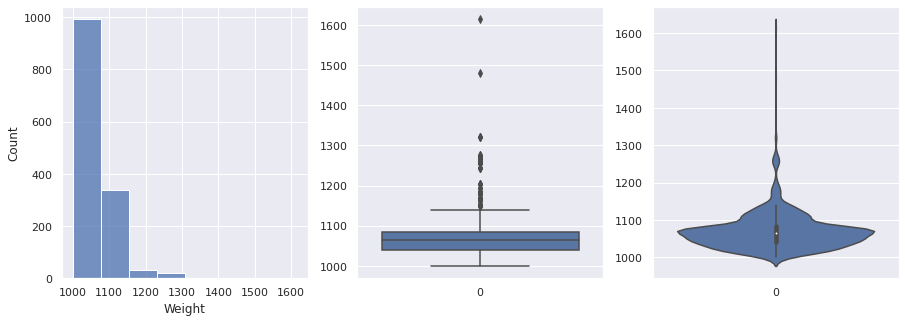

In [621]:
graficar_info_variable(df.Weight)

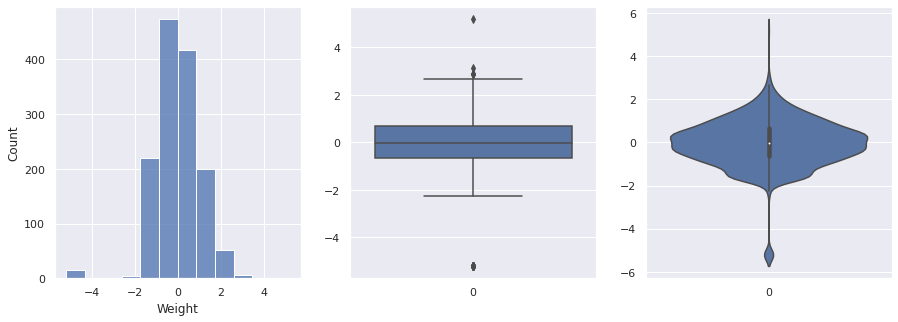

In [622]:
df.Weight = qt.fit_transform(df.Weight.values.reshape(-1, 1))
graficar_info_variable(df.Weight, 12)

In [623]:
porcentaje_outliers(df.Weight)

Porcentaje de outliers:  1.5129682997118155


In [624]:
df = quitar_outliers(df, df.Weight)
porcentaje_outliers(df.Weight)

Porcentaje de outliers:  0.0


#### Univariate Feature Selection

In [625]:
m = SelectKBest(score_func=f_regression, k=4)
r = m.fit(x, y)
results_df=pd.DataFrame(r.scores_)
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score'])

,Feature,Score
1,Mfg_Month,0.471934
13,BOVAG_Guarantee,1.135864
6,Automatic,1.570992
34,Petrol,2.130519
32,CNG,2.245020
25,Radio,2.520447
30,Radio_cassette,2.678580
33,Diesel,4.206904
9,Gears,5.733157
24,Power_Steering,5.948894


In [626]:
columns = ['Mfg_Year', 'Age_08_04', 'Boardcomputer','Automatic_airco', 'Weight', 'KM', 'CD_Player', 'Airco', 'Powered_Windows',
           'Central_Lock', 'HP', 'ABS', 'Price']

In [627]:
df = df[columns]

In [628]:
y = df.Price.values.reshape(-1, 1)
x = df.drop(columns=['Price'])

In [629]:
x.KM = standar_scaler.fit_transform(x.KM.values.reshape(-1, 1))
x.Weight = standar_scaler.fit_transform(x.Weight.values.reshape(-1, 1))
#x.Mfg_Year = standar_scaler.fit_transform(x.Mfg_Year.values.reshape(-1, 1))
#x.HP = standar_scaler.fit_transform(x.HP.values.reshape(-1, 1))
y = standar_scaler.fit_transform(y)

In [630]:
#x.head()

In [631]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
ml = sm.OLS(y_train, sm.add_constant(x_train))
ml_results = ml.fit()
y_pred = ml_results.predict(sm.add_constant(x_test))
print("RMSE: %.4f" % mean_squared_error(y_test,y_pred, squared=False))

RMSE: 0.3484


In [632]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     631.4
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:09:17   Log-Likelihood:                -340.60
No. Observations:                 956   AIC:                             707.2
Df Residuals:                     943   BIC:                             770.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -802.7544     84.501     -9.500      0.000    -968.587    -636.922
Mfg_Year            0.4013      0.042      9.516      0.000       0.319       0.484
Age_08_04          -0.0043      0.003     -1.239      0.216      -0.011       0.003
Boardcomputer      -0.1027      0.036     -2.824      0.005      -0.174      -0.031
Automatic_airco     0.7516      0.057     13.114      0.000       0.639       0.864
Weight              0.1609      0.014     11.387      0.000       0.133       0.189
KM                 -0.1512      0.015    -10.079      0.000      -0.181      -0.122
CD_Player           0.0752      0.033      2.298      0.022       0.011       0.139
Airco               0.0699      0.029      2.387      0.017       0.012       0.127
Powered_Windows     0.1306      0.050      2.623      0.009       0.033       0.228
Central_Lock       -0.0174      0.050     -0.351      0.725      -0.115       0.080
HP                  0.0055      0.001      6.732      0.000       0.004       0.007
ABS                -0.1026      0.032     -3.229      0.001      -0.165      -0.040
==============================================================================
Omnibus:                       55.460   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.197
Skew:                           0.130   Prob(JB):                     6.77e-43
Kurtosis:                       5.193   Cond. No.                     1.50e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [633]:
columns = ['Mfg_Year', 'Automatic_airco', 'Weight', 'KM', 'CD_Player', 'Airco', 'Powered_Windows','HP', 'ABS', 'Price']

In [634]:
df = df[columns]

In [635]:
y = df.Price.values.reshape(-1, 1)
x = df.drop(columns=['Price'])

In [636]:
x.KM = standar_scaler.fit_transform(x.KM.values.reshape(-1, 1))
x.Weight = standar_scaler.fit_transform(x.Weight.values.reshape(-1, 1))
y = standar_scaler.fit_transform(y)

In [637]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
ml = sm.OLS(y_train, sm.add_constant(x_train))
ml_results = ml.fit()
y_pred = ml_results.predict(sm.add_constant(x_test))
print("RMSE: %.4f" % mean_squared_error(y_test,y_pred, squared=False))

RMSE: 0.3515


In [638]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     835.4
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:10:06   Log-Likelihood:                -345.26
No. Observations:                 956   AIC:                             710.5
Df Residuals:                     946   BIC:                             759.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -855.7255     25.937    -32.993      0.000    -906.626    -804.825
Mfg_Year            0.4276      0.013     32.967      0.000       0.402       0.453
Automatic_airco     0.7598      0.057     13.250      0.000       0.647       0.872
Weight              0.1648      0.014     11.717      0.000       0.137       0.192
KM                 -0.1563      0.015    -10.494      0.000      -0.186      -0.127
CD_Player           0.0584      0.032      1.805      0.071      -0.005       0.122
Airco               0.0738      0.029      2.526      0.012       0.016       0.131
Powered_Windows     0.1147      0.028      4.157      0.000       0.061       0.169
HP                  0.0054      0.001      6.519      0.000       0.004       0.007
ABS                -0.0993      0.032     -3.133      0.002      -0.162      -0.037
==============================================================================
Omnibus:                       63.083   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.374
Skew:                           0.167   Prob(JB):                     1.73e-52
Kurtosis:                       5.423   Cond. No.                     4.60e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [639]:
df.corr().style.background_gradient(cmap='Greens')

,Mfg_Year,Automatic_airco,Weight,KM,CD_Player,Airco,Powered_Windows,HP,ABS,Price
Mfg_Year,1.000000,0.399724,0.454852,-0.559004,0.498813,0.379584,0.249281,0.136888,0.406780,0.884135
Automatic_airco,0.399724,1.000000,0.350820,-0.268915,0.226938,0.227961,0.189104,0.242171,0.109300,0.547581
Weight,0.454852,0.350820,1.000000,-0.061212,0.237376,0.355751,0.248909,0.162541,0.153938,0.542207
KM,-0.559004,-0.268915,-0.061212,1.000000,-0.270188,-0.160172,-0.146317,-0.256311,-0.191132,-0.602732
CD_Player,0.498813,0.226938,0.237376,-0.270188,1.000000,0.241454,0.174838,0.081124,0.188085,0.464783
Airco,0.379584,0.227961,0.355751,-0.160172,0.241454,1.000000,0.541193,0.246784,0.223680,0.431336
Powered_Windows,0.249281,0.189104,0.248909,-0.146317,0.174838,0.541193,1.000000,0.262080,0.084611,0.341972
HP,0.136888,0.242171,0.162541,-0.256311,0.081124,0.246784,0.262080,1.000000,0.049613,0.296352
ABS,0.406780,0.109300,0.153938,-0.191132,0.188085,0.223680,0.084611,0.049613,1.000000,0.312312
Price,0.884135,0.547581,0.542207,-0.602732,0.464783,0.431336,0.341972,0.296352,0.312312,1.000000


In [640]:
# Valores Ajustados
fitted_values = ml_results.fittedvalues

# Valores residuales
residuals = ml_results.resid

#residuales estandarizados
lm_resid_stand = ml_results.get_influence().resid_studentized_internal

#raiz de los residuales normalizados absolutos
lm_resid_norm_abs_sqrt = np.sqrt(np.abs(lm_resid_stand))

#residuales absolutos
lm_resid_abs = np.abs(residuals)

In [641]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:ylabel='Count'>

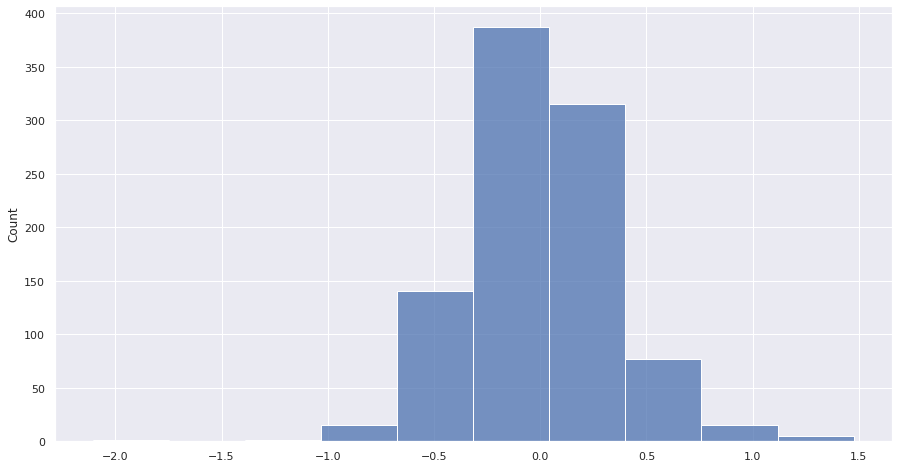

In [642]:
# Residuales
sns.histplot(ml_results.resid, bins=10)

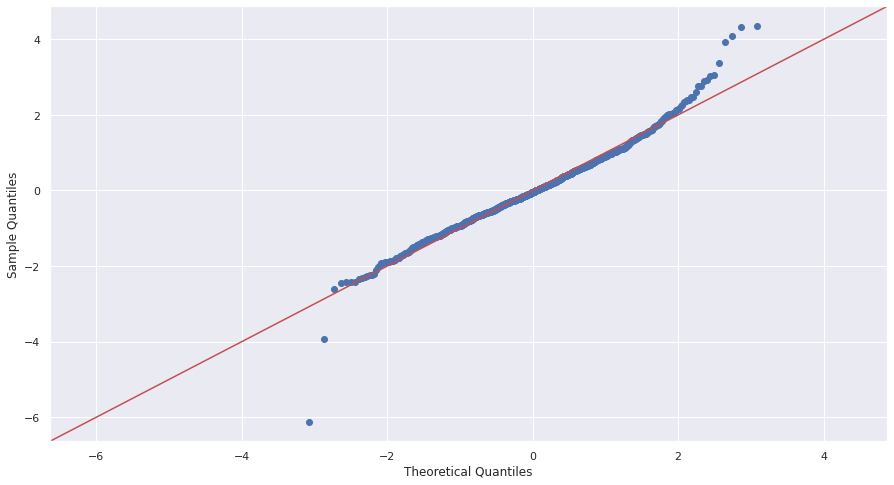

In [643]:
def grafico_qqplot():
    fig = sm.qqplot(lm_resid_stand,line='45')
    plt.show()

grafico_qqplot()

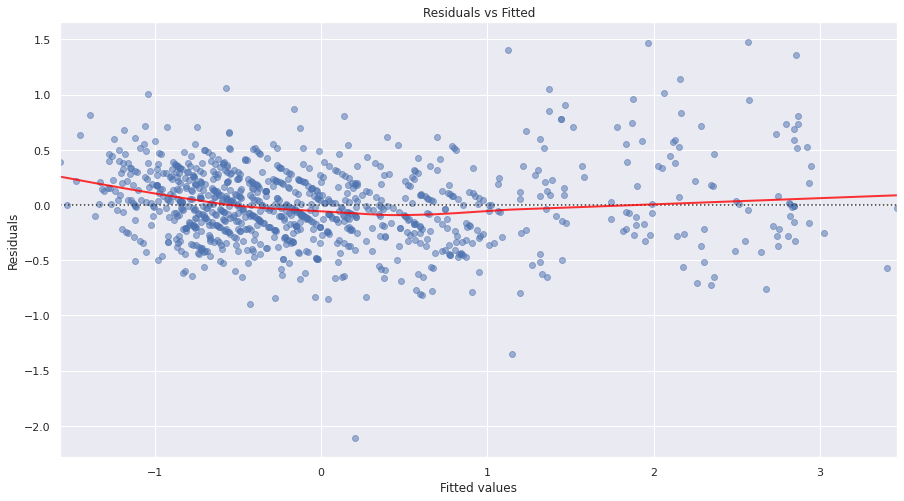

In [644]:
def residuales_vs_ajustados():
    plot = sns.residplot(x=fitted_values, y=residuals, lowess=True,
                         scatter_kws={'alpha': 0.5},
                         line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})

    # Titel and labels
    plot.set_title('Residuals vs Fitted')
    plot.set_xlabel('Fitted values')
    plot.set_ylabel('Residuals')
residuales_vs_ajustados()